This notebook is used to train the models using `MLFLow`, if you want to see the results for the best models, refer to the `4_evaluation` notebook.

In [1]:
import os

import mlflow
from mlflow.models import infer_signature
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

os.sys.path.append(os.path.abspath('../src'))
from data import loader
from data import preprocessor

mapname = 'Town01'

In [2]:
def create_and_train_model(model, args):
    """
    Function to create and train a model with given parameters.

    Args:
        model: The model to be trained.
        args: Arguments for training the model.

    Returns:
        result: The result of the training process.
    """
    result = {}
    # Train model with current hyperparameters
    print(f"Params: {args}")
    md = model(**args)
    md.fit(X_train, y_train)
    # Predict on the validation set
    y_pred = md.predict(X_val)
    # Log training results
    result["f1_score"] = f1_score(y_val, y_pred, average='weighted')
    result["accuracy"] = accuracy_score(y_val, y_pred)
    result["recall"] = recall_score(y_val, y_pred, average='weighted')
    result["precision"] = precision_score(y_val, y_pred, average='weighted')
    result["model"] = md

    return result

In [3]:
def objective(params, model_name):
    """
    Objective function for hyperparameter optimization.
    This function will be called by Hyperopt for each trial.
    """
    with mlflow.start_run(nested=True, run_name=f"{model_name}_{params}"):
        # Log hyperparameters being tested
        mlflow.log_params(params)

        # Train model with current hyperparameters
        result = create_and_train_model(
            model,
            args=params
        )

        # Log training results
        mlflow.log_metrics(
            {
                "accuracy": result["accuracy"],
                "recall": result["recall"],
                "precision": result["precision"],
                "f1_score": result["f1_score"],
            }
        )

        # Log the trained model
        mlflow.sklearn.log_model(
            result["model"], name=model_name, signature=signature)

        # Return loss for Hyperopt (it minimizes)
        return {"loss": -result["f1_score"], "status": STATUS_OK, "model": f'{model_name}_{params}'}

In [4]:
def run_experiments(run_name, max_evals, search_space, data_name, features_names, model_name):
    # Create or set experiment

    print(
        f"This will run {max_evals} trials to find optimal hyperparameters...")

    with mlflow.start_run(run_name=run_name):

        mlflow.set_tag("model_type", model_name)

        # Log experiment metadata
        mlflow.log_params(
            {
                "optimization_method": "Tree-structured Parzen Estimator (TPE)",
                "max_evaluations": max_evals,
                "objective_metric": "log_loss",
                "dataset": data_name,
                "features": features_names,
            }
        )

        # Run optimization
        trials = Trials()
        objective_with_name = partial(objective, model_name=model_name)

        best_params = fmin(
            fn=objective_with_name,
            space=search_space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            verbose=True,
        )

        # Find and log best results
        best_trial = min(trials.results, key=lambda x: x["loss"])
        best_f1_score = -best_trial["loss"]

        # Log optimization results
        mlflow.log_params(best_params)
        mlflow.log_params({"best_model": best_trial["model"]})
        mlflow.log_metrics(
            {
                "best_f1_score": best_f1_score,
                "total_trials": len(trials.trials),
                "optimization_completed": 1,
            }
        )

    return best_f1_score 


In [13]:
def save_tsne(embeddings, labels, target_label, title, figs_path='../results/figures/tsne'):

    # Create a boolean mask for each class
    mask_real = labels == 0
    mask_sumo = labels == 1

    plt.figure(figsize=(6, 6))

    # Plot each class with a label
    plt.scatter(
        embeddings[mask_real, 0],
        embeddings[mask_real, 1],
        color='blue',
        s=2,
        label='Real'
    )

    plt.scatter(
        embeddings[mask_sumo, 0],
        embeddings[mask_sumo, 1],
        color='red',
        s=2,
        label=target_label
    )
    plt.legend(markerscale=4, fontsize=14, loc='upper right')  # Increase marker size and legend font size, place at top right
    plt.title(title, fontsize=18)
    plt.savefig(f'{figs_path}/{"_".join(title.lower().split())}.png')
    plt.show()

In [7]:
client = mlflow.tracking.MlflowClient("http://127.0.0.1:8080")
mlflow.set_tracking_uri("http://127.0.0.1:8080")

## Preparing the Data

We are not going to use gyro_z from SUMO since it is not directly provided by the simulator.

In [8]:
data_path = '../data'
uah_training = pd.read_csv(f'{data_path}/base/training_set_uah.csv')
uah_validation = pd.read_csv(f'{data_path}/base/validation_set_uah.csv')

carla_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/carla/carla_fixed.csv').drop(columns=['origin'])
carla_llm = pd.read_csv(f'{data_path}/merged/{mapname}/carla/carla_llm.csv').drop(columns=['origin'])

sumo_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/sumo/sumo_fixed.csv').drop(columns=['origin'])
sumo_llm = pd.read_csv(f'{data_path}/merged/{mapname}/sumo/sumo_llm.csv').drop(columns=['origin'])

carla_uah_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/carla_uah/carla_uah_fixed.csv')
carla_uah_llm = pd.read_csv(f'{data_path}/merged/{mapname}/carla_uah/carla_uah_llm.csv')

sumo_uah_fixed = pd.read_csv(f'{data_path}/merged/{mapname}/sumo_uah/sumo_uah_fixed.csv')
sumo_uah_llm = pd.read_csv(f'{data_path}/merged/{mapname}/sumo_uah/sumo_uah_llm.csv')

In [9]:
sumo_columns_to_keep = sumo_fixed.columns.tolist()
carla_columns_to_keep = carla_fixed.columns.tolist()
print(f"Columns to keep for SUMO: {sumo_columns_to_keep}")
print(f"Columns to keep for CARLA: {carla_columns_to_keep}")

Columns to keep for SUMO: ['acc', 'angle', 'speed', 'label']
Columns to keep for CARLA: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'angle', 'label', 'acc']


In [10]:
window_size = 10
step_size = 5
one_hot_keys = {
    'normal': 0,
    'aggressive': 1
}

Defining the search space for each model

In [11]:
max_evals = 5

search_space_rf = {
    "n_estimators": hp.choice("n_estimators", [20, 50, 100, 200, 500]),
    "max_depth": hp.choice("max_depth", [None, 5, 10, 20, 50]),
}
search_space_svc = {
    "C": hp.choice("C", [0.01, 0.05, 0.1, 0.5, 1]),  # Regularization parameter
    "kernel": hp.choice("kernel", ["rbf"]),  # Kernel type
    "gamma": hp.choice("gamma", [0.001, 0.01, 0.1, 1, 10]),  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}
search_space_svc_linear = {
    "C": hp.choice("C", [10**-4, 10**-3, 10**-2, 0.1, 1])  # Regularization parameter
}
search_space_xgb = {
    "n_estimators": hp.choice("n_estimators", [200, 500, 700, 1000]),
    "max_depth": hp.choice("max_depth", [None, 5, 10]),
    "learning_rate": hp.choice("learning_rate", [0.001, 0.01, 0.1, 0.2, 0.3]),  # Learning rate
    "subsample": hp.choice("subsample", [0.5, 0.7, 1.0]),  # Subsample ratio of the training instances
    "colsample_bytree": hp.choice("colsample_bytree", [0.5, 0.7, 1.0]),  # Subsample ratio of columns when constructing each tree
}

# Train on Real test on Synthetic

By training a model on real data and testing on synthetic data, we verify synthetic data’s fidelity with the real-world.

## SUMO

In [128]:
X_train, y_train = preprocessor.sliding_windows(uah_training[sumo_columns_to_keep], window_size=window_size, step_size=step_size)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys)
signature = infer_signature(X_train, y_train)

### Fixed

In [129]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on SUMO Fixed data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_SUMO_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [130]:
X_val, y_val = preprocessor.sliding_windows(sumo_fixed, window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_SUMO_Fixed')
data_name = 'TRTS_SUMO_Fixed'

In [131]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

Params: {'max_depth': 10, 'n_estimators': 100}       
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/3908b66b28824654940aff43ee4a5570

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125

Params: {'max_depth': 10, 'n_estimators': 50}                                   
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/810196a5efef409dba096a84eb2e2068

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125   

Params: {'max_depth': 20, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/216e72019a5845afac560518a07235e6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125   

Params: {'max_depth': 10, 'n_est

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/41c335c8188249edbf0897b3cb2f50c0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125

Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}                                   
🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/62a9064d5869417aa4a034e99a81bd86

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125   

Params: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}                               
🏃 View run SVC_{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/a3ae9be4c447487f8338f992fca9e1c5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125    

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'r

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/15392958f2c248c4a897984dc528dc50

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125    

100%|██████████| 5/5 [03:27<00:00, 41.49s/trial, best loss: -0.36553212012481184]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/b177a8c548ff43acac1defa312045130
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 700, 'subsample': 0.5}
🏃 View run XGBClassifier_{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 700, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/621583713237610125/runs/4533a1480f1a4a19968c4f0a9bca96c9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/621583713237610125


0.502739604758718

### LLM

In [132]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on SUMO LLM data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_SUMO_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [133]:
X_val, y_val = preprocessor.sliding_windows(sumo_llm, window_size=10, step_size=5)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_SUMO_LLM')
data_name = 'TRTS_SUMO_LLM'

In [134]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/1342c804424847519740c1d66cb86799

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068

Params: {'max_depth': 5, 'n_estimators': 500}                                    
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/51ac41823f5c433a87b10b1c9ca935ac

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068    

Params: {'max_depth': None, 'n_estimators': 500}                                 
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/c11bc5471e3c4e27ad08986cc153dc5d

🧪 View experiment at: http://127.0.0.1:8080/#/expe

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/4a4666143ba1435785210e34b8a88c1f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068   

Params: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}                            
 60%|██████    | 3/5 [01:52<01:13, 36.96s/trial, best loss: -0.4048805573715453]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/76afc344714d4d94abe8c93cadb25d77

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068   

Params: {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}                               
 80%|████████  | 4/5 [02:34<00:38, 38.81s/trial, best loss: -0.4048805573715453]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/fae09ebe982744799f8863081bbbddc4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068   

100%|██████████| 5/5 [03:45<00:00, 45.19s/trial, best loss: -0.4048805573715453]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/3631240d3dc641fcba38aa386edd462b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 1000, 'subsample': 0.7}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 1000, 'subsample': 0.7} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/e00dab7ca61348968a51f23a04f5d2e3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068

Pa

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': None, 'n_estimators': 200, 'subsample': 1.0} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/ca91fb5e90ff490a83774a012a7d0d02

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068   

Params: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}
🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/839960217607977068/runs/9a40912ce2c2467fb3a8b36df7461473

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/839960217607977068   

Params: {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
🏃 View run XGBClassifier_{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7} at: http://127.0.0.1:8080/#/e

0.5426947484521164

## CARLA

In [135]:
X_train, y_train = preprocessor.sliding_windows(uah_training[carla_columns_to_keep], window_size=10, step_size=5)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys)
signature = infer_signature(X_train, y_train)

### Fixed

In [136]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on CARLA Fixed data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_CARLA_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [137]:
X_val, y_val = preprocessor.sliding_windows(carla_fixed, window_size=10, step_size=5)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_CARLA_Fixed')
data_name = 'TRTS_CARLA_Fixed'

In [138]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 20}         
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/ce656471426d4140904f4a76a4920110

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174

Params: {'max_depth': 20, 'n_estimators': 200}                                  
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/4ba307c5b90d481c92a6b71767e8debb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174   

Params: {'max_depth': 50, 'n_estimators': 500}                                  
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/000c8e55b3fa4a958eaa68c645690cb7

🧪 View experiment at: http://127.0.0.1:8080/#/experiment

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/3b82ad6dc5a74a35976b9f289dcf2340

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                
 20%|██        | 1/5 [00:57<03:51, 57.97s/trial, best loss: -0.2422968812901423]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/b9f4e733d0b0483aa15d6ed9fe6a087a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174   

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                
 40%|████      | 2/5 [01:46<02:37, 52.38s/trial, best loss: -0.4331910871073824]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/ff6d7cdf259f44a6b2363ced31142585

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174   

Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}                             
 60%|██████    | 3/5 [02:32<01:38, 49.40s/trial, best loss: -0.4331910871073824]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/4d0d7a375cb54b579c3964008ab1c683

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174   

Params: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}                              
 80%|████████  | 4/5 [03:28<00:52, 52.09s/trial, best loss: -0.4331910871073824]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/b17acddce3484d03b7448ff605c0b74c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174   

100%|██████████| 5/5 [04:15<00:00, 51.11s/trial, best loss: -0.4331910871073824]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/b3fc37331925470b92d18fc9f97796bc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 700, 'subsample': 0.7}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 700, 'subsample': 0.7} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/32a11a00fa55463fb428d790bfac85d6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174

Params:

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7} at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/d91145e76c68407b8e11945cd0a7c07f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174   

100%|██████████| 5/5 [00:29<00:00,  5.80s/trial, best loss: -0.4331910871073824]
🏃 View run trts-xgb-sweep at: http://127.0.0.1:8080/#/experiments/893549182304293174/runs/6ba917ca5b0e42dcace54adc1c3a7b5e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/893549182304293174


0.4331910871073824

### LLM

In [139]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to TRTS on CARLA LLM data."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="TRTS_CARLA_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [140]:
X_val, y_val = preprocessor.sliding_windows(carla_llm, window_size=10, step_size=5)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys)

mlflow.set_experiment('TRTS_CARLA_LLM')
data_name = 'TRTS_CARLA_LLM'

In [141]:
model = RandomForestClassifier
run_experiments('trts-rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=sumo_columns_to_keep)
model = SVC
run_experiments('trts-svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=sumo_columns_to_keep)
model = xgb.XGBClassifier
run_experiments('trts-xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=sumo_columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 50}         
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/b0d7e5beb87a4261ab6c3481229e0dbd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896

Params: {'max_depth': 5, 'n_estimators': 50}                                    
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/5abed41fc1a84cbe9cd870e787eb14b7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896   

Params: {'max_depth': 50, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/be3d787874bf42d886aac845b6e77efe

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/c1e3d707b96a4e1dbcce86b99778be15

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896

Params: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}                             
 20%|██        | 1/5 [00:58<03:53, 58.27s/trial, best loss: -0.33282944613852833]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/def4cdb2043a4523a5d4e4e362dd62a3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896    

Params: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}                                
 40%|████      | 2/5 [01:55<02:52, 57.47s/trial, best loss: -0.33282944613852833]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/54e6a6693bc7411eb443bdeaaaa78727

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896    

Params: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/2036893f09fe4bb69b2d166835e168d6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896    

Params: {'C': 0.05, 'gamma': 0.001, 'kernel': 'rbf'}                             
 80%|████████  | 4/5 [03:28<00:51, 51.66s/trial, best loss: -0.38299829511888167]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/b633d6421b4a4d2bb0305ec0738438e6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896    

100%|██████████| 5/5 [04:25<00:00, 53.16s/trial, best loss: -0.38299829511888167]
🏃 View run trts-svc-sweep at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/697b59e27b04446b81f3bfe2de3ff69e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 500, 'subsample': 1.0}
🏃 View run XGBClassifier_{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 500, 'subsample': 1.0} at: http://127.0.0.1:8080/#/experiments/453070281431362896/runs/780a5c9f49724bd09d696933e6c10201

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/453070281431362896


0.4996436326093469

# Discriminative Score and UMAP

We seek to understand how well a classifier can separate the real and the synthetic data to determine how indistiguishable they are.

Here, there is no need to fine-tune hyperparameters, since the default parameters work.

We are also going to plot the UMAP projection of the data, to see how separated it is.

In [15]:
X_uah_disc_sumo = uah_training[sumo_columns_to_keep].drop(columns=['label'])
X_uah_disc_carla = uah_training[carla_columns_to_keep].drop(columns=['label'])
y_uah_disc = np.zeros(len(X_uah_disc_carla)) # 0 for real data and 1 for synthetic data

## SUMO

In [16]:
X_sumo_disc_fixed, y_sumo_disc_fixed = sumo_fixed.drop(columns=['label']), np.ones(len(sumo_fixed))
X_sumo_disc_llm, y_sumo_disc_llm = sumo_llm.drop(columns=['label']), np.ones(len(sumo_llm))

### Fixed

In [17]:
X, y = pd.concat([X_sumo_disc_fixed, X_uah_disc_sumo], axis=0, ignore_index=True), np.concat([y_sumo_disc_fixed, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

F1 Score: 1.0
Accuracy: 1.0


In [18]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
sumo_fixed_embedding = reducer.fit_transform(scaled_data)

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


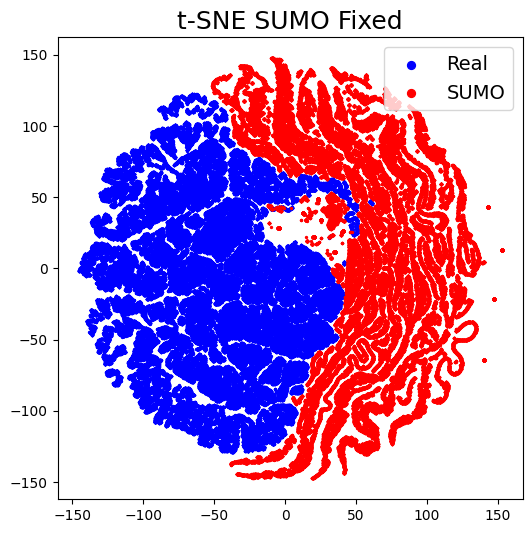

In [19]:
save_tsne(sumo_fixed_embedding, y, 'SUMO', 't-SNE SUMO Fixed')

### LLM

In [20]:
X, y = pd.concat([X_sumo_disc_llm, X_uah_disc_sumo], axis=0, ignore_index=True), np.concat([y_sumo_disc_llm, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

F1 Score: 1.0
Accuracy: 1.0


In [21]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
sumo_llm_embedding = reducer.fit_transform(scaled_data)

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


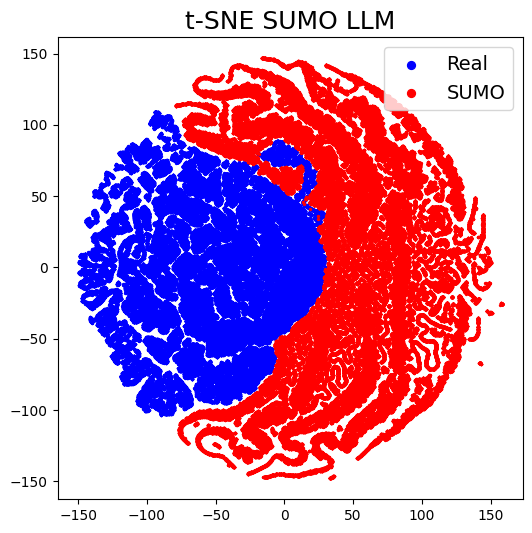

In [22]:
save_tsne(sumo_llm_embedding, y, 'SUMO', 't-SNE SUMO LLM')

## CARLA

In [23]:
X_carla_disc_fixed, y_carla_disc_fixed = carla_fixed.drop(columns=['label']), np.ones(len(carla_fixed))
X_carla_disc_llm, y_carla_disc_llm = carla_llm.drop(columns=['label']), np.ones(len(carla_llm))

### Fixed

In [24]:
X, y = pd.concat([X_carla_disc_fixed, X_uah_disc_carla], axis=0, ignore_index=True), np.concat([y_carla_disc_fixed, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [50]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

F1 Score: 1.0
Accuracy: 1.0


In [25]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
carla_fixed_embedding = reducer.fit_transform(scaled_data)

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


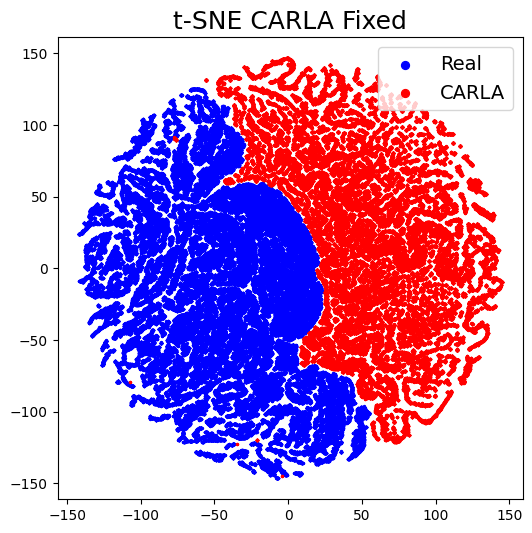

In [26]:
save_tsne(carla_fixed_embedding, y, 'CARLA', 't-SNE CARLA Fixed')

### LLM

In [27]:
X, y = pd.concat([X_carla_disc_llm, X_uah_disc_carla], axis=0, ignore_index=True), np.concat([y_carla_disc_llm, y_uah_disc], axis=0)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

F1 Score: 1.0
Accuracy: 1.0


In [28]:
data = X.values
scaled_data = StandardScaler().fit_transform(data)
reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
carla_llm_embedding = reducer.fit_transform(scaled_data)

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


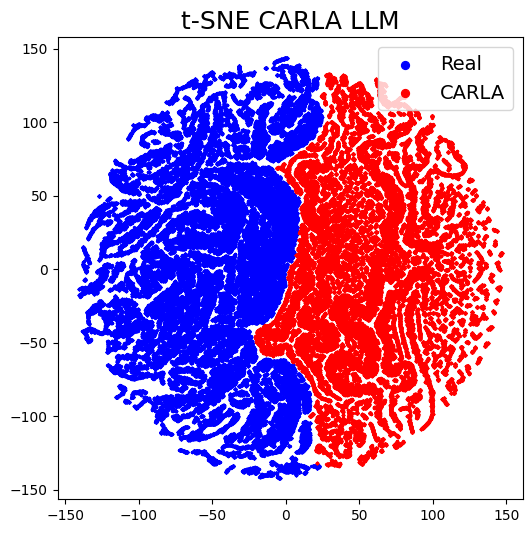

In [29]:
save_tsne(carla_llm_embedding, y, 'CARLA', 't-SNE CARLA LLM')

# Predictive Scores

Here we train on different combinations of real and synthetic data and test on real data only in order to verify the quality of the data for real-world applications.

## Real Only

In [142]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH driveset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [143]:
columns_to_keep = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'angle', 'speed', 'label']

X_train, y_train = preprocessor.sliding_windows(uah_training[columns_to_keep], window_size=window_size, step_size=step_size)
X_val, y_val = preprocessor.sliding_windows(uah_validation[columns_to_keep], window_size=window_size, step_size=step_size)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH')
data_name = 'UAH'

In [144]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/819130163325130393/runs/ce3ffa4cf5d74513a22549a3358daa6f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/819130163325130393

Params: {'max_depth': 50, 'n_estimators': 50}                                   
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/819130163325130393/runs/22a86da8fc404f7783eacd0236905c30

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/819130163325130393   

Params: {'max_depth': None, 'n_estimators': 500}                                
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/819130163325130393/runs/c47450a68b8b495e8a3e5aa351311ad2

🧪 View experiment at: http://127.0.0.1:8080/#/experim

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/819130163325130393/runs/114ecf8b3edb4818ac49b54f3d4cd139

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/819130163325130393   

Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/819130163325130393/runs/c90f46131d2148e38f510cda5121a896

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/819130163325130393   

100%|██████████| 5/5 [04:23<00:00, 52.69s/trial, best loss: -0.7887581233260065]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/819130163325130393/runs/19b19cc2e24e44678b67a906936d0e9a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/819130163325130393
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.01}                                  
🏃 View run LinearSVC_{'C': 0.01} at: http://127.0.0.1:8080/#/ex

0.7735115125719207

## SUMO Only

In [145]:
# SUMO
X_sumo_fixed, y_sumo_fixed = preprocessor.sliding_windows(sumo_fixed, window_size=window_size, step_size=step_size)
X_sumo_llm, y_sumo_llm = preprocessor.sliding_windows(sumo_llm, window_size=window_size, step_size=step_size)

In [146]:
# Getting the validation for SUMO variables
print("Columns to keep for validation:", sumo_columns_to_keep)

X_val_base, y_val = preprocessor.sliding_windows(uah_validation[sumo_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc', 'angle', 'speed', 'label']


### Fixed

In [147]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the SUMO Fixed dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="SUMO_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [148]:
X_train, y_train = X_sumo_fixed, y_sumo_fixed

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('SUMO_Fixed')
data_name = 'SUMO_Fixed'

In [149]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 500}       
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/231265708412075804/runs/f0b5dcc92f7a4382b47cbdc82fc1f9d1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/231265708412075804

Params: {'max_depth': 50, 'n_estimators': 100}                                   
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/231265708412075804/runs/eff9bbfb08f548f2b7aa4ec6fb26cce4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/231265708412075804    

Params: {'max_depth': 10, 'n_estimators': 100}                                   
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/231265708412075804/runs/6835d13e6d464e52918bb7e2e1f3776a

🧪 View experiment at: http://127.0.0.1:8080/#/exper

0.33730962743803933

### LLM

In [150]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the SUMO LLM dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="SUMO_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [151]:
X_train, y_train = X_sumo_llm, y_sumo_llm

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

mlflow.set_experiment('SUMO_LLM')
data_name = 'SUMO_LLM'

In [152]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/520308586629931043/runs/18bf1b63fe344fbf9b251e66f8fe4b60

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/520308586629931043

Params: {'max_depth': 5, 'n_estimators': 200}                                    
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/520308586629931043/runs/42a72fd903574d68aabeadccc14195f6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/520308586629931043    

Params: {'max_depth': None, 'n_estimators': 100}                                 
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/520308586629931043/runs/d8248a46800d4353b4eab51a55cca968

🧪 View experiment at: http://127.0.0.1:8080/#/expe

0.4159742000728149

## Carla Only

In [153]:
X_carla_fixed, y_carla_fixed = preprocessor.sliding_windows(carla_fixed, window_size=window_size, step_size=step_size)
X_carla_llm, y_carla_llm = preprocessor.sliding_windows(carla_llm, window_size=window_size, step_size=step_size)

In [154]:
# Getting the validation for SUMO variables
print("Columns to keep for validation:", carla_columns_to_keep)
X_val_base, y_val = preprocessor.sliding_windows(uah_validation[carla_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'angle', 'label', 'acc']


### Fixed

In [155]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the CARLA Fixed dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="CARLA_Fixed", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [156]:
X_train, y_train = X_carla_fixed, y_carla_fixed

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

mlflow.set_experiment('CARLA_Fixed')
data_name = 'CARLA_Fixed'

In [157]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': None, 'n_estimators': 500}     
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/e6e3cca691794fe795c60b5884fb73ed

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880

Params: {'max_depth': 20, 'n_estimators': 200}                                   
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/2bd83833cb774e0ab27faf2cd3247432

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880    

Params: {'max_depth': 10, 'n_estimators': 20}                                    
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/ebadaedf46c1493ea01b3e86b80e7893

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880  

Params: {'max_depth': 5, 'n_estimators': 50}                                    
 

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/96e3ac95c7374f648212456f8d2ec82e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

Params: {'max_depth': 50, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/b029321c0e90465198488ddb3fccc313

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

100%|██████████| 5/5 [02:07<00:00, 25.45s/trial, best loss: -0.4791392724406395]
🏃 View run rf-sweep at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/563a2c6113ee4b8997a61df13526b986
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}        
  0%|          | 0/5 [00:00<?,

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/2eda4b3054714421b657f3ed0aaf167a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880

Params: {'C': 1, 'gamma': 10, 'kernel': 'rbf'}                                   
 20%|██        | 1/5 [00:34<02:16, 34.10s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/ec38f19b158c4bfa903b7762dff2307f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880    

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                 
 40%|████      | 2/5 [01:22<02:07, 42.45s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/df659cb7df3547db8918154c38a12a37

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

Params: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}                            
 60%|██████    | 3/5 [01:43<01:05, 32.64s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/69c0b905237040878e11e1a8c4cad355

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

Params: {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}                                 
 80%|████████  | 4/5 [02:15<00:32, 32.43s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/2a00d98227834cf6af741607bfd36312

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

100%|██████████| 5/5 [02:33<00:00, 30.79s/trial, best loss: -0.3335592240143389]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/587302ed4f53423ebf30d2f6aef5ee6b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1}                                     
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/fdaf5b9c910449efa9faec2aea98ef7f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880

Params: {'C': 1}                                                                
 20%|██        | 1/5 [00:27<01:49, 27.35s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/ffa382d1736a47368bdd4b0073bf76ab

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

Params: {'C': 0.01}                                                             
 40%|████      | 2/5 [00:54<01:22, 27.39s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run LinearSVC_{'C': 0.01} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/f703b27ef66342d98ea7d6bb047973de

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

Params: {'C': 1}                                                                
 60%|██████    | 3/5 [00:59<00:33, 16.93s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/6ae74279eec34e7b8967efcb190ed634

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

Params: {'C': 0.1}                                                              
 80%|████████  | 4/5 [01:27<00:21, 21.22s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/e963937237dd4fbaac4a3220326a48e7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880   

100%|██████████| 5/5 [01:36<00:00, 19.29s/trial, best loss: -0.3335592240143389]
🏃 View run svc-linear-sweep at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/890f967290194502a5a934267eb0c5ef
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880
This will run 5 trials to find optimal hyperparameters...
Params: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0} at: http://127.0.0.1:8080/#/experiments/115922994890695880/runs/b3c8452254934979a7c48b20cf1dfa0c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/115922994890695880

Params: {'colsample_bytree': 1.

0.46565504997268153

### LLM

In [158]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the CARLA LLM dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="CARLA_LLM", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [159]:
X_train, y_train = X_carla_llm, y_carla_llm

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

mlflow.set_experiment('CARLA_LLM')
data_name = 'CARLA_LLM'

In [160]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/2b6bb0fb4cfb47508127abeace1ceee8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078

Params: {'max_depth': 10, 'n_estimators': 20}                                   
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/f0b2431c73994bebaacd9e2d6c60941f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078   

Params: {'max_depth': 5, 'n_estimators': 100}                                   
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/d064427466cb481f86ee503d3e08700e

🧪 View experiment at: http://127.0.0.1:8080/#/experiment

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/061a0a61c0654c7ca2171e877eb38b2d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078

Params: {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}                              
 20%|██        | 1/5 [00:33<02:15, 33.88s/trial, best loss: -0.33310749162724596]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/f30cfce6d1c2407c97d5f6a21596ab8c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078    

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                 
 40%|████      | 2/5 [01:06<01:39, 33.18s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/5c3a2ebec3e34714bced97cde1cdf2f7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078   

Params: {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}                                
 60%|██████    | 3/5 [01:40<01:07, 33.53s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/c7e39759923e42b6a1077495bd3803f4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078   

Params: {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}                                 
 80%|████████  | 4/5 [02:15<00:34, 34.26s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/05a32c6a839d4b6ba8051fd03f9c40f0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078   

100%|██████████| 5/5 [02:49<00:00, 33.80s/trial, best loss: -0.3335592240143389]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/ebe737e2f1384443bb1865237fc89e7d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1}                                     
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/364685698816811078/runs/4e7b24d23317430fb3a8360b0a19bea2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/364685698816811078

Params: {'C': 0.1}                                                               
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experiments/364685698816811078

0.4939274573240015

## Real + SUMO

In [161]:
sumo_uah_fixed_20 = preprocessor.fill_synthetic_data(sumo_uah_fixed, 0.2)
sumo_uah_llm_20 = preprocessor.fill_synthetic_data(sumo_uah_llm, 0.2)

sumo_uah_fixed_60 = preprocessor.fill_synthetic_data(sumo_uah_fixed, 0.6)
sumo_uah_llm_60 = preprocessor.fill_synthetic_data(sumo_uah_llm, 0.6)

sumo_uah_fixed_100 = preprocessor.fill_synthetic_data(sumo_uah_fixed, 1)
sumo_uah_llm_100 = preprocessor.fill_synthetic_data(sumo_uah_llm, 1)


In [162]:
X_sumo_uah_fixed_20, y_sumo_uah_fixed_20 = preprocessor.sliding_windows(sumo_uah_fixed_20, window_size=window_size, step_size=step_size)
X_sumo_uah_llm_20, y_sumo_uah_llm_20 = preprocessor.sliding_windows(sumo_uah_llm_20, window_size=window_size, step_size=step_size)

X_sumo_uah_fixed_60, y_sumo_uah_fixed_60 = preprocessor.sliding_windows(sumo_uah_fixed_60, window_size=window_size, step_size=step_size)
X_sumo_uah_llm_60, y_sumo_uah_llm_60 = preprocessor.sliding_windows(sumo_uah_llm_60, window_size=window_size, step_size=step_size)

X_sumo_uah_fixed_100, y_sumo_uah_fixed_100 = preprocessor.sliding_windows(sumo_uah_fixed_100, window_size=window_size, step_size=step_size)
X_sumo_uah_llm_100, y_sumo_uah_llm_100 = preprocessor.sliding_windows(sumo_uah_llm_100, window_size=window_size, step_size=step_size)

In [163]:
print("Columns to keep for validation:", sumo_columns_to_keep)

X_val_base, y_val = preprocessor.sliding_windows(uah_validation[sumo_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc', 'angle', 'speed', 'label']


## Real + SUMO (20%)

### Fixed

In [164]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO Fixed (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_Fixed_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [165]:
X_train, y_train = X_sumo_uah_fixed_20, y_sumo_uah_fixed_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_Fixed_20')
data_name = 'UAH_SUMO_Fixed_20'

In [166]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': None, 'n_estimators': 20}      
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/596165481629841552/runs/f60085b4607947e0a1804b9af9210ce3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/596165481629841552

Params: {'max_depth': 5, 'n_estimators': 50}                                    
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/596165481629841552/runs/69a870b7d2884f65b6a31dd075927c82

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/596165481629841552   

Params: {'max_depth': 50, 'n_estimators': 20}                                   
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/596165481629841552/runs/c742e3b7b36d4a0a89e05f5da91996fe

🧪 View experiment at: http://127.0.0.1:8080/#/experiment

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/596165481629841552/runs/7c6a9f5c9bb74e0bb2c913424771850b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/596165481629841552   

Params: {'C': 0.05, 'gamma': 10, 'kernel': 'rbf'}                               
 80%|████████  | 4/5 [01:57<00:34, 34.00s/trial, best loss: -0.7015316563569836]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/596165481629841552/runs/848225a19c7b4bd3a8463e69e0de2241

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/596165481629841552   

100%|██████████| 5/5 [02:52<00:00, 34.52s/trial, best loss: -0.7015316563569836]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/596165481629841552/runs/8ecd49bc91044de6be29a18461e30196
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/596165481629841552
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.01}                                  
🏃 View run LinearSVC_{'C': 0.01} at: http://127.0.0.1:8080/#/experiments/596165481629841552/runs/72996761b07a489fb1eb3312f60a5b54

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/596165481629841552

Params: {'C': 1}                                                                
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/5961654816298415

0.7370910032637138

### LLM

In [167]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO LLM (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_LLM_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [168]:
X_train, y_train = X_sumo_uah_llm_20, y_sumo_uah_llm_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_LLM_20')
data_name = 'UAH_SUMO_LLM_20'

In [169]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 100}        
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/83fd5c83b2f34509ab9155cb6d8aad45

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544

Params: {'max_depth': 10, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/4d934339f3eb4fc28e514b6201f0bf7b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544   

Params: {'max_depth': 10, 'n_estimators': 500}                                  
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/b6da606ea8a3453c8d17c8b986ab5e37

🧪 View experiment at: http://127.0.0.1:8080/#/experimen

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/8c745a2ebc9846f4b09404bb89ea135d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544

Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/3ba429e9e4b14f9ba27727d1fa28c123

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544   

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                
🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/ec922873b37e41a89eaac27ff7b6bae8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544  

Params: {'C': 0.05, 'gamma': 10, 'kernel': 'rbf'}                              
 60%|██████    | 3/5 [01:53<01:05, 32.53s/trial, best lo

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/92af77006aaf41bbbf834acc6a5370bd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544  

Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/97a16a9b689743cf9b22701e1b4b58f7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544  

100%|██████████| 5/5 [03:06<00:00, 37.40s/trial, best loss: -0.6916439792105177]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/318252292058062544/runs/248fb424de124307b73769e432b1040c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/318252292058062544
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1}                                     
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/expe

0.7252382344254025

## Real + SUMO (60%)

### Fixed

In [170]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO Fixed (60%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_Fixed_60", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [171]:
X_train, y_train = X_sumo_uah_fixed_60, y_sumo_uah_fixed_60

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_Fixed_60')
data_name = 'UAH_SUMO_Fixed_60'

In [172]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 500}       
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/c66af1c64b044a80a8ca4550004c5b7f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/764588472886884330

Params: {'max_depth': 10, 'n_estimators': 50}                                   
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/305c3549b9e2471db1d70a88c6868d72

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/764588472886884330   

Params: {'max_depth': 10, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/4632da91d8ef46cfa2a9c49be8c5d9fc

🧪 View experiment at: http://127.0.0.1:8080/#/experimen

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/de82829c9b154a2ab1585f7818544343

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/764588472886884330   

Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}                                   
🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/e66d7587f9bc4887a8a74c79e1349dc6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/764588472886884330   

100%|██████████| 5/5 [02:51<00:00, 34.22s/trial, best loss: -0.7237554234531884]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/b3bf434e01dc45a7be5c195eafff77d9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/764588472886884330
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.1}                                   
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experi

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7} at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/22a04a8b61654106bb4a6a62c3ba2a45

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/764588472886884330   

Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 700, 'subsample': 0.5}
🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 700, 'subsample': 0.5} at: http://127.0.0.1:8080/#/experiments/764588472886884330/runs/1c1a79b5706542638d3fd80ab95004db

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/764588472886884330   

Params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 1.0}
🏃 View run XGBClassifier_{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 1.0} at: http://127.0.0.1:8080/#/

0.7301638676399987

### LLM

In [173]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO LLM (60%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_LLM_60", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [174]:
X_train, y_train = X_sumo_uah_llm_60, y_sumo_uah_llm_60

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_LLM_60')
data_name = 'UAH_SUMO_LLM_60'

In [175]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': None, 'n_estimators': 500}     
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/305863925903451489/runs/6d7518749fea4e0a84f0df33f43bdf88

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/305863925903451489

Params: {'max_depth': 50, 'n_estimators': 50}                                 
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/305863925903451489/runs/554f0fdc29724c719feb6e3744807ec5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/305863925903451489 

Params: {'max_depth': 5, 'n_estimators': 20}                                  
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/305863925903451489/runs/af09261e36d148aaae5bfe51b5ee7dd1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/305

0.7341023141094059

## Real + SUMO (100%)

### Fixed

In [176]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO Fixed (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_Fixed_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [177]:
X_train, y_train = X_sumo_uah_fixed_100, y_sumo_uah_fixed_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_Fixed_100')
data_name = 'UAH_SUMO_Fixed_100'

In [178]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/727116162143983866/runs/82c5e44da8f242f382c157cfd1b1d059

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/727116162143983866

Params: {'max_depth': 10, 'n_estimators': 20}                                  
🏃 View run RandomForestClassifier_{'max_depth': 10, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/727116162143983866/runs/a00795847d194288ba08828cd02b8ea4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/727116162143983866  

Params: {'max_depth': 20, 'n_estimators': 50}                                   
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/727116162143983866/runs/54c165eb24cc403d9c8dbb843fbbd80d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/

0.7328894680452058

### LLM

In [179]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + SUMO LLM (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_SUMO_LLM_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [180]:
X_train, y_train = X_sumo_uah_llm_100, y_sumo_uah_llm_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_SUMO_LLM_100')
data_name = 'UAH_SUMO_LLM_100'

In [181]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': None, 'n_estimators': 20}      
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/8bb18573eb454a7697e0c266a397c748

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/730010159651501045

Params: {'max_depth': 50, 'n_estimators': 200}                                  
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/d9c345fc36d841d18fe28621a3820a87

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/730010159651501045   

Params: {'max_depth': 20, 'n_estimators': 20}                                   
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/a4d5aed64d2c4dc3af7944dd3a7773d9

🧪 View experiment at: http://127.0.0.1:8080/#/experime

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/9138323e1ddc4f2fb56e9600a6b32a4b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/730010159651501045   

Params: {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/8010dc9c200746ffb3edf05294bc82f6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/730010159651501045   

Params: {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}                               
 60%|██████    | 3/5 [02:06<01:17, 38.57s/trial, best loss: -0.7237554234531884]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/b82de1416bc94d4dac34468e83a39845

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/730010159651501045   

Params: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}                               
🏃 View run SVC_{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/f01e981954da4e4d956c159c875c431f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/730010159651501045   

100%|██████████| 5/5 [03:11<00:00, 38.26s/trial, best loss: -0.7239699809614671]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/730010159651501045/runs/6c870e21cc334689819118ed4d9a9607
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/730010159651501045
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.0001}                                
🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:808

0.7322852294845013

## Real + CARLA

In [182]:
carla_uah_fixed_20 = preprocessor.fill_synthetic_data(carla_uah_fixed, 0.2)
carla_uah_llm_20 = preprocessor.fill_synthetic_data(carla_uah_llm, 0.2)

carla_uah_fixed_60 = preprocessor.fill_synthetic_data(carla_uah_fixed, 0.6)
carla_uah_llm_60 = preprocessor.fill_synthetic_data(carla_uah_llm, 0.6)

carla_uah_fixed_100 = preprocessor.fill_synthetic_data(carla_uah_fixed, 1)
carla_uah_llm_100 = preprocessor.fill_synthetic_data(carla_uah_llm, 1)


In [183]:
X_carla_uah_fixed_20, y_carla_uah_fixed_20 = preprocessor.sliding_windows(carla_uah_fixed_20, window_size=window_size, step_size=step_size)
X_carla_uah_llm_20, y_carla_uah_llm_20 = preprocessor.sliding_windows(carla_uah_llm_20, window_size=window_size, step_size=step_size)

X_carla_uah_fixed_60, y_carla_uah_fixed_60 = preprocessor.sliding_windows(carla_uah_fixed_60, window_size=window_size, step_size=step_size)
X_carla_uah_llm_60, y_carla_uah_llm_60 = preprocessor.sliding_windows(carla_uah_llm_60, window_size=window_size, step_size=step_size)

X_carla_uah_fixed_100, y_carla_uah_fixed_100 = preprocessor.sliding_windows(carla_uah_fixed_100, window_size=window_size, step_size=step_size)
X_carla_uah_llm_100, y_carla_uah_llm_100 = preprocessor.sliding_windows(carla_uah_llm_100, window_size=window_size, step_size=step_size)

In [184]:
print("Columns to keep for validation:", carla_columns_to_keep)

X_val_base, y_val = preprocessor.sliding_windows(uah_validation[carla_columns_to_keep], window_size=window_size, step_size=step_size)
y_val = preprocessor.one_hot_encode(y_val, one_hot_keys=one_hot_keys)

Columns to keep for validation: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'angle', 'label', 'acc']


## Real + CARLA (20%)

### Fixed

In [185]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA Fixed (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_Fixed_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [186]:
X_train, y_train = X_carla_uah_fixed_20, y_carla_uah_fixed_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_Fixed_20')
data_name = 'UAH_CARLA_Fixed_20'

In [187]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/1acabe36909540afb795abb614734b69

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/979556896000275190

Params: {'max_depth': 20, 'n_estimators': 200}                                  
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/808e3be3c57a4c8695da0e7535639c23

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/979556896000275190   

Params: {'max_depth': 20, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/8034d0ee07c84722b8120db3f9302922

🧪 View experiment at: http://127.0.0.1:8080/#/experime

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/36dd22fd704e49f69ca851fae9522eed

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/979556896000275190   

Params: {'C': 0.5, 'gamma': 10, 'kernel': 'rbf'}                                
 40%|████      | 2/5 [02:03<03:21, 67.03s/trial, best loss: -0.5200582843179186]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/059db6c158484994a7f846e5f5cd0731

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/979556896000275190   

Params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}                                   
 60%|██████    | 3/5 [03:55<02:55, 87.59s/trial, best loss: -0.5200582843179186]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/97a3bced8d1848e5861b0496ee310481

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/979556896000275190   

Params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/b65a91d110694eb6b360442a468b7754

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/979556896000275190   

100%|██████████| 5/5 [06:10<00:00, 74.07s/trial, best loss: -0.5384076886439152]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/979556896000275190/runs/a92c99287e80473ebd1efbc319235cd9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/979556896000275190
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.0001}                                
🏃 View run LinearSVC_{'C': 0.0001} at: http://127.0.0.1:8080/#

0.6620195462356778

### LLM

In [188]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA LLM (20%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_LLM_20", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [189]:
X_train, y_train = X_carla_uah_llm_20, y_carla_uah_llm_20

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_LLM_20')
data_name = 'UAH_CARLA_LLM_20'

In [190]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 50}         
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/a4fc7607da754571b85edd3d18d402ae

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513

Params: {'max_depth': 50, 'n_estimators': 20}                                   
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/b0c477f6718d4134b1ef84275f3ecc58

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513   

Params: {'max_depth': 20, 'n_estimators': 500}                                  
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/0f8fa525c9fc4373aab724f4753638fb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/1146a9877a954dac9e917796557104f3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513    

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/45d6e6fac8984c0a8d5eefa649a0a957

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513    

Params: {'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/8e02350ff0d54a63b91b678b99d3701d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513   

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                
 80%|████████  | 4/5 [03:36<00:48, 48.60s/trial

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/96dbc536e3d94edba9d7daf264c35132

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513   

100%|██████████| 5/5 [04:46<00:00, 57.32s/trial, best loss: -0.5626391037469958]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/775b5eddd71a418593ff7131f28ca5d3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1}                                     
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/162264197747572513/runs/f0fec19facd94529b0376c8a3286cbda

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/162264197747572513

Params: {'C': 0.001}                                                            
🏃 View run LinearSVC_{'C': 0.001} at: http://127.0.0.1:8080/#/experiments/1622641977475725

0.658784894475942

## Real + CARLA (60%)

### Fixed

In [191]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA Fixed (60%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_Fixed_60", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [192]:
X_train, y_train = X_carla_uah_fixed_60, y_carla_uah_fixed_60

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_Fixed_60')
data_name = 'UAH_CARLA_Fixed_60'

In [193]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 20}        
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/988409490d29460ab76c3fd42a19eb95

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670

Params: {'max_depth': 5, 'n_estimators': 500}                                  
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/83bd0f452a7d4a53a37eebb75ae10b61

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670  

Params: {'max_depth': 5, 'n_estimators': 50}                                   
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/80755f8a6a794cb387f765e5543b154f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/d4826418083f46c2b08989d6b6eaeda4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670    

Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}                                 
🏃 View run SVC_{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/fed97ebcb65c45e0acf3db39aba9539a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670    

Params: {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}                                  
 60%|██████    | 3/5 [02:47<01:48, 54.19s/trial, best loss: -0.5626391037469958]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/7d3810d57d394c8b96153956a77b2dad

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670   

Params: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}                            
🏃 View run SVC_{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/25cfb0d9372a4135a0eea0a7351a6a15

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670   

100%|██████████| 5/5 [04:54<00:00, 58.98s/trial, best loss: -0.5626391037469958]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/9c517f42006440eabd1a8e34129239b1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.01}                                  
🏃 View run LinearSVC_{'C': 0.01} at: http://127.0.0.1:8080

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run XGBClassifier_{'colsample_bytree': 0.5, 'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0} at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/0480e975aeb844fb8b8c32b89d09c5cb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670   

100%|██████████| 5/5 [00:37<00:00,  7.52s/trial, best loss: -0.6244918561783198]
🏃 View run xgb-sweep at: http://127.0.0.1:8080/#/experiments/875475706037318670/runs/146699e1bc3c4d2d8a7b56a727214cc9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/875475706037318670


0.6244918561783198

### LLM

In [194]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA LLM (60%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_LLM_60", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [195]:
X_train, y_train = X_carla_uah_llm_60, y_carla_uah_llm_60

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_LLM_60')
data_name = 'UAH_CARLA_LLM_60'

In [196]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 20, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/bea9a6f1d3454c5bb2192b0f175f0e24

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753

Params: {'max_depth': 50, 'n_estimators': 500}                                  
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/6b4b4e3d0ef14378a87269456d697640

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753   

Params: {'max_depth': 50, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/c63ae8c750b7495a9bc425a3ef64596f

🧪 View experiment at: http://127.0.0.1:8080/#/experime

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/bf14a2301e9248a384570598a8c91ae5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753

Params: {'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/1dcb38c88f97485e8a709991f0867767

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753   

Params: {'C': 0.05, 'gamma': 0.001, 'kernel': 'rbf'}                            
🏃 View run SVC_{'C': 0.05, 'gamma': 0.001, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/f562b417a9074f52805ee902d20545b2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753   

Params: {'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.05, 'gamma': 0.01, 'kernel

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/797166171dcb4dfb91ff6f12856fa0d6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753   

100%|██████████| 5/5 [04:35<00:00, 55.11s/trial, best loss: -0.5356984519547826]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/cc73f6f8305642b99fa7c956e0428f52
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1}                                     
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:8080/#/experiments/496229470573444753/runs/bd0882f623b244378ebcbd7fde94a07f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/496229470573444753

Params: {'C': 0.1}                                                              
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:8080/#/experiments/49622947057344475

0.6537327961539646

## Real + CARLA (100%)

### Fixed

In [197]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA Fixed (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_Fixed_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [198]:
X_train, y_train = X_carla_uah_fixed_100, y_carla_uah_fixed_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_Fixed_100')
data_name = 'UAH_CARLA_Fixed_100'

In [199]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 50, 'n_estimators': 200}       
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/3e27ea3d8f1744daabe510984eb7de4e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157

Params: {'max_depth': 50, 'n_estimators': 20}                                   
🏃 View run RandomForestClassifier_{'max_depth': 50, 'n_estimators': 20} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/e8dcab0d37e846c789e65b0fa0c2afa1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157   

Params: {'max_depth': 20, 'n_estimators': 100}                                  
🏃 View run RandomForestClassifier_{'max_depth': 20, 'n_estimators': 100} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/6f59f5e413c64e9bb26cdba9275785b7

🧪 View experiment at: http://127.0.0.1:8080/#/experimen

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/b691844c49ba4c64b1674403b39bdb64

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                
 20%|██        | 1/5 [01:28<05:53, 88.43s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/fa55999785204b398cd3b721b55e951a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157   

Params: {'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}                                
 40%|████      | 2/5 [02:59<04:29, 89.96s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/8f88e41220d541f5994252a9c8520237

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157   

Params: {'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}                              
 60%|██████    | 3/5 [04:30<03:00, 90.28s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/71a8b5bc7e674552b9eb95536fb314b6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157   

Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}                             
🏃 View run SVC_{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/600b185493cc46aa82448ff977386bc8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157   

100%|██████████| 5/5 [05:39<00:00, 67.94s/trial, best loss: -0.4867422728192607]
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/194635463440888157/runs/7c97c7c95ca64d51a2c73986148a44c9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/194635463440888157
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 0.1}                                   
🏃 View run LinearSVC_{'C': 0.1} at: http://127.0.0.1:808

0.6479794764266431

### LLM

In [200]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Experiment to train models on the UAH + CARLA LLM (100%) dataset."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "driver-behavior-prediction",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
try:
    driver_behavior_experiment = client.create_experiment(
        name="UAH_CARLA_LLM_100", tags=experiment_tags
    )
except mlflow.exceptions.RestException as e:
    print(f"Experiment already exists: {e}")

In [201]:
X_train, y_train = X_carla_uah_llm_100, y_carla_uah_llm_100

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val_base)
y_train = preprocessor.one_hot_encode(y_train, one_hot_keys=one_hot_keys)

signature = infer_signature(X_train, y_train)
mlflow.set_experiment('UAH_CARLA_LLM_100')
data_name = 'UAH_CARLA_LLM_100'

In [202]:
model = RandomForestClassifier
run_experiments('rf-sweep', max_evals=max_evals, search_space=search_space_rf, data_name=data_name, model_name = 'RandomForestClassifier', features_names=columns_to_keep)
model = SVC
run_experiments('svc-sweep', max_evals=max_evals, search_space=search_space_svc, data_name=data_name, model_name = 'SVC', features_names=columns_to_keep)
model = LinearSVC
run_experiments('svc-linear-sweep', max_evals=max_evals, search_space=search_space_svc_linear, data_name=data_name, model_name = 'LinearSVC', features_names=columns_to_keep)
model = xgb.XGBClassifier
run_experiments('xgb-sweep', max_evals=max_evals, search_space=search_space_xgb, data_name=data_name, model_name = 'XGBClassifier', features_names=columns_to_keep)

This will run 5 trials to find optimal hyperparameters...
Params: {'max_depth': 5, 'n_estimators': 50}         
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 50} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/649a73c456364dfc9a0dd91f4a45b358

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312

Params: {'max_depth': None, 'n_estimators': 500}                                
🏃 View run RandomForestClassifier_{'max_depth': None, 'n_estimators': 500} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/859ea31050aa4ebd85b9eccc86e961a1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312   

Params: {'max_depth': 5, 'n_estimators': 200}                                   
🏃 View run RandomForestClassifier_{'max_depth': 5, 'n_estimators': 200} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/5dd614a0b65b4d629724fe2a77ccbce1

🧪 View experiment at: http://127.0.0.1:8080/#/experimen

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/1a6af45ef7c94382986ef0a101c16205

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312

Params: {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}                               
 20%|██        | 1/5 [00:35<02:23, 35.92s/trial, best loss: -0.3335592240143389]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/2cbeac2ea1694c67bb4dc9b06ce8dace

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312   

Params: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}                               
🏃 View run SVC_{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/42d74c20957f44deb21da62ef6172619

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312   

Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}                                 
 60%|██████    | 3/5 [02:39<01:44, 52.49s/trial, best loss: -0.35981263484620574]

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🏃 View run SVC_{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/20d101069c164fa1a2a954c8d613f7f5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312    

Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}                              
🏃 View run SVC_{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'} at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/15543d33e81e4269a2f82ab72c42ae30

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312    

100%|██████████| 5/5 [04:22<00:00, 52.56s/trial, best loss: -0.4867422728192607] 
🏃 View run svc-sweep at: http://127.0.0.1:8080/#/experiments/864268533532999312/runs/b57e83e905e54101acb0d8e0b7006713
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/864268533532999312
This will run 5 trials to find optimal hyperparameters...
Params: {'C': 1}                                     
🏃 View run LinearSVC_{'C': 1} at: http://127.0.0.1:808

0.6232494004444332